# Compute the potential-field data

Compute the potential-field data produced by the geological source simulated in the notebook `aula_7c_modelo_prismas_mag.ipynb`.

### Things we have to import

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [5]:
import time

In [6]:
import pickle

In [7]:
from gravmag import data_structures, utils, aux_vedo, constants, check
from gravmag.models import rectangular_prism as rp
from gravmag import plot_functions as plf

In [8]:
import vedo

In [9]:
# set the backend for vedo
vedo.settings.default_backend= 'vtk'
#vedo.settings.default_backend= '2d'

In [10]:
def model_cut(model, pmin, pmax):
    check.are_rectangular_prisms(model)
    check.is_integer(x=pmin, positive=True, include_zero=True)
    check.is_integer(x=pmax, positive=True, include_zero=True)
    if pmin >= pmax:
        raise ValueError('pmin must be greater than pmax')
    nprisms = model['x1'].size
    if pmin >= nprisms:
        raise ValueError('pmin must be smaller than num. of model prisms')
    if pmax >= nprisms:
        raise ValueError('pmax must be smaller than num. of model prisms')
    selected_model = dict()
    for element in model.keys():
        selected_model[element] = model[element][pmin:pmax+1]
    return selected_model

### Load the model

In [11]:
model = pickle.load(open('aula_7c/synthetic_bodies_mag.pickle', 'rb'))

In [12]:
# model properties
print("(xmin, xmax) = ({:.3f}, {:.3f}) m".format(model['prisms']['x1'].min(), model['prisms']['x2'].max()))
print("(ymin, ymax) = ({:.3f}, {:.3f}) m".format(model['prisms']['y1'].min(), model['prisms']['y2'].max()))
print("(top min, top max) = ({:.3f}, {:.3f}) m".format(model['prisms']['z1'].min(), model['prisms']['z1'].max()))
print("(bottom min, bottom max) = ({:.3f}, {:.3f}) m".format(model['prisms']['z2'].min(), model['prisms']['z2'].max()))
print("number of prisms: {}".format(model['prisms']['x1'].size))

(xmin, xmax) = (-5188.914, 4874.313) m
(ymin, ymax) = (-3908.024, 6313.953) m
(top min, top max) = (0.000, 1000.000) m
(bottom min, bottom max) = (113.185, 1500.000) m
number of prisms: 305


In [13]:
# compute the Cartesian components of magnetization
mx, my, mz = utils.magnetization_components(
    np.vstack([model['mag-intensities'], model['mag-inclinations'], model['mag-declinations']]).T
)

In [14]:
# Cartesian components of the total magnetization
h_hat = utils.unit_vector(inc=model['mag-inclinations'][0], dec=model['mag-declinations'][0])

In [15]:
# compute a normalized horizontal projection of h_hat to plot
h_hat_horizontal = h_hat[:2]/np.linalg.norm(h_hat[:2])

### Points were we compute the synthetic data

In [16]:
data_points = dict()

In [17]:
# number of points along x and y
data_points['shape'] = (50, 50)

# minimum x, maximum x, minimum y and maximum y
data_points['area'] = [-5000, 5000, -4000, 6000]

In [18]:
# grid of computation points
data_points['grid'] = data_structures.grid_xy(
    area=data_points['area'], shape=data_points['shape'], z0=-100
)

In [19]:
# number of points along x and y
print('n. data = {}'.format(data_points['shape'][0]*data_points['shape'][1]))

# grid spacing
data_dx, data_dy = data_structures.grid_xy_spacing(area=data_points['area'], shape=data_points['shape'])
print('dx = {:.3f} m | dy = {:.3f} m'.format(data_dx, data_dy))

n. data = 2500
dx = 204.082 m | dy = 204.082 m


In [20]:
file_name = 'data_points.pickle'
with open('aula_7c/'+file_name, 'wb') as f:
    pickle.dump(data_points, f)

In [21]:
X, Y = data_structures.grid_xy_to_full_matrices_view(
    x=data_points['grid']['x'],
    y=data_points['grid']['y'],
    shape=data_points['shape']
)

### Main field

In [22]:
main_field = dict()

In [31]:
# grid orientation
main_field['grid_orientation'] = 'xy'

# horizontal coordinates of the center
xc = (data_points['grid']['x'][0] + data_points['grid']['x'][-1]) / 2
yc = (data_points['grid']['y'][0] + data_points['grid']['y'][-1]) / 2

# inclination (degrees)
main_field['I'] = data_structures.grid_xy_full_matrix_to_flatten(
    grid=3 - 1e-4*(X-xc) + 3e-4*(Y-yc) + 1e-8*(X-xc)*(X-xc) + 1e-8*(Y-yc)*(Y-yc),
    grid_orientation=main_field['grid_orientation']
)

# declination (degrees)
main_field['D'] = data_structures.grid_xy_full_matrix_to_flatten(
    grid=45 + 6e-5*(X-xc) + 1e-4*(Y-yc) + 3e-9*(X-xc)*(X-xc) + 4e-9*(Y-yc)*(Y-yc),
    grid_orientation=main_field['grid_orientation']
)

# intensity (nT)
main_field['F'] = data_structures.grid_xy_full_matrix_to_flatten(
    grid=23400 + 3e-4*(X-xc) + 5e-4*(Y-yc) + 0*(X-xc)*(X-xc) + 0*(Y-yc)*(Y-yc),
    grid_orientation=main_field['grid_orientation']
)

# Cartesian components of the main field
cosI = np.cos(np.deg2rad(main_field['I']))
sinI = np.sin(np.deg2rad(main_field['I']))
cosD = np.cos(np.deg2rad(main_field['D']))
sinD = np.sin(np.deg2rad(main_field['D']))
main_field['x'] = main_field['F']*cosI*cosD
main_field['y'] = main_field['F']*cosI*sinD
main_field['z'] = main_field['F']*sinI

In [32]:
# Compute the average main field
mean_I = np.mean(main_field['I'])
mean_D = np.mean(main_field['D'])
cos_mean_I = np.cos(np.deg2rad(mean_I))
sin_mean_I = np.sin(np.deg2rad(mean_I))
cos_mean_D = np.cos(np.deg2rad(mean_D))
sin_mean_D = np.sin(np.deg2rad(mean_D))
Fx_hat = cos_mean_I*cos_mean_D
Fy_hat = cos_mean_I*sin_mean_D
Fz_hat = sin_mean_I
F_hat = np.array([Fx_hat, Fy_hat, Fz_hat])

In [33]:
# compute a normalized horizontal projection of F_hat to plot
F_hat_horizontal = F_hat[:2]/np.linalg.norm(F_hat[:2])

In [26]:
titles = [
    'I', 'D', 'F', 
    'Fx', 'Fy', 'Fz'
]
units = [
    'degree', 'degree', 'nT', 
    'nT', 'nT', 'nT'
]
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

In [27]:
fields = ['I', 'D', 'F', 'x', 'y', 'z']

In [28]:
mosaic_elements = ['a', 'b', 'c', 'd', 'e', 'f']

In [29]:
color = 3*(0.4,)

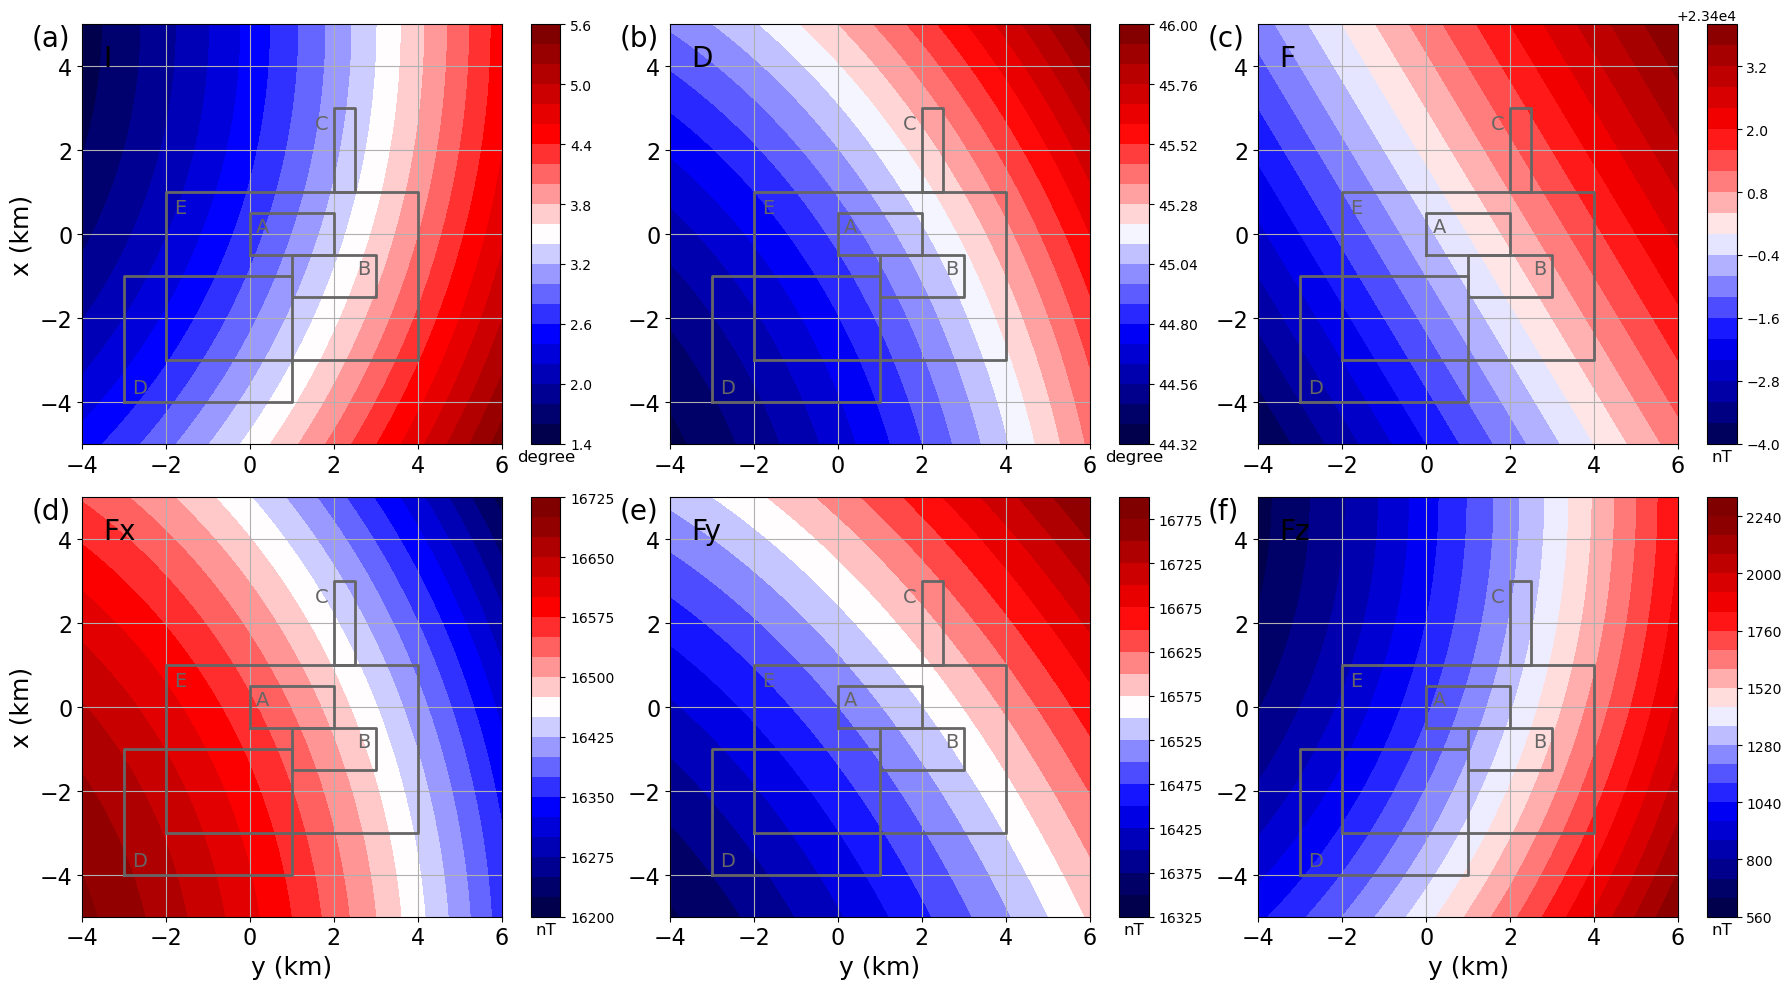

In [34]:
fig = plt.figure(layout= 'tight', figsize=(18,10))
mosaic = fig.subplot_mosaic('''
                            abc
                            def
                            ''')
# tensor components
for (element, field, title, label, unit) in zip(
    mosaic_elements, fields, titles, labels, units
):
    ax = mosaic[element]
    ax.axis('scaled')
    im = ax.contourf(
        Y*0.001, X*0.001, 
        data_structures.grid_xy_full_flatten_to_matrix(
            data=main_field[field],
            grid_orientation=main_field['grid_orientation'],
            shape=data_points['shape']
            ), 
            20, cmap='seismic', 
        vmin=np.min(main_field[field]), vmax=np.max(main_field[field])
    )
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="7%", pad="7%")
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    cb.ax.tick_params(labelsize=10, top=False, bottom=True, labeltop=False, labelbottom=True)
    cb.ax.set_xlabel(unit, fontsize=12, loc='center')
    ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
    ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid()
    ax.annotate(label, xy=(-0.12, 0.95), xycoords='axes fraction', fontsize=20)
    ax.annotate(title, xy=(0.05, 0.90), xycoords='axes fraction', fontsize=20)
    plf.model_boundaries(
        ax,
        model=model_cut(model['prisms'], pmin=0, pmax=4),
        color=color,
        style='-',
        width='2'
    )
    ax.annotate(text='A', xy=(0.15, 0.05), fontsize=14, color=color)
    ax.annotate(text='B', xy=(2.55, -0.95), fontsize=14, color=color)
    ax.annotate(text='C', xy=(1.55, 2.50), fontsize=14, color=color)
    ax.annotate(text='D', xy=(-2.80, -3.80), fontsize=14, color=color)
    ax.annotate(text='E', xy=(-1.80, 0.50), fontsize=14, color=color)

for element in ['a','d']:
    mosaic[element].set_ylabel('x (km)', fontsize=18)
for element in ['d','e', 'f']:
    mosaic[element].set_xlabel('y (km)', fontsize=18)
    
plt.show()

In [39]:
file_name = 'main_field.pickle'
with open('aula_7c/'+file_name, 'wb') as f:
    pickle.dump(main_field, f)

### Synthetic crustal data

In [35]:
crustal_field = dict()

#### Noise-free magnetic inductioncomponents  (in nT)

In [36]:
# Compute the tensor components
mag_components = ['x', 'y', 'z']
for component in mag_components:
    crustal_field[component] = rp.mag(
          coordinates=data_structures.grid_xy_to_full_flatten(
              grid=data_points['grid'],
              grid_orientation=main_field['grid_orientation']
          ), 
          prisms=model['prisms'], 
          mx = mx, 
          my = my, 
          mz = mz, 
          field=component
    )

In [37]:
# amplitude of anomalous magnetic field
crustal_field['b'] = np.sqrt(crustal_field['x']**2 + crustal_field['y']**2 + crustal_field['z']**2)

# Compute the approximated total-field anomaly (Blakely, 1996, p. 179)
crustal_field['atfa'] = F_hat[0]*crustal_field['x'] + F_hat[1]*crustal_field['y'] + F_hat[2]*crustal_field['z']

# Total-field anomaly
crustal_field['tfa'] = np.sqrt(
    (main_field['x'] + crustal_field['x'])**2 +
    (main_field['y'] + crustal_field['y'])**2 +
    (main_field['z'] + crustal_field['z'])**2
) - main_field['F']

In [38]:
# true RTP anomaly
crustal_field['rtp'] = rp.mag(
    coordinates=data_structures.grid_xy_to_full_flatten(
        grid=data_points['grid'],
        grid_orientation=main_field['grid_orientation']
    ), 
    prisms=model['prisms'], 
    mx=np.zeros_like(model['prisms']['x1']), 
    my=np.zeros_like(model['prisms']['x1']), 
    mz=model['mag-intensities'], 
    field='z'
)

#### Save data

In [40]:
file_name = 'crustal_field.pickle'
with open('aula_7c/'+file_name, 'wb') as f:
    pickle.dump(crustal_field, f)

### Plot the computed gravity disturbance with Matplotlib

In [41]:
titles = ['bx (nT)', 'by (nT)', 'bz (nT)', 'b (nT)', 'tfa (nT)', 'atfa (nT)']
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

In [42]:
mag_fields = ['x', 'y', 'z', 'b', 'tfa', 'atfa']

In [43]:
ranges = []
for field in mag_fields:
    ranges.append(np.max(np.abs(crustal_field[field])))
ranges = 0.9*np.max(np.array(ranges))

In [44]:
mosaic_elements = ['a', 'b', 'c', 'd', 'e', 'f']

In [47]:
color = 3*(0.4,)

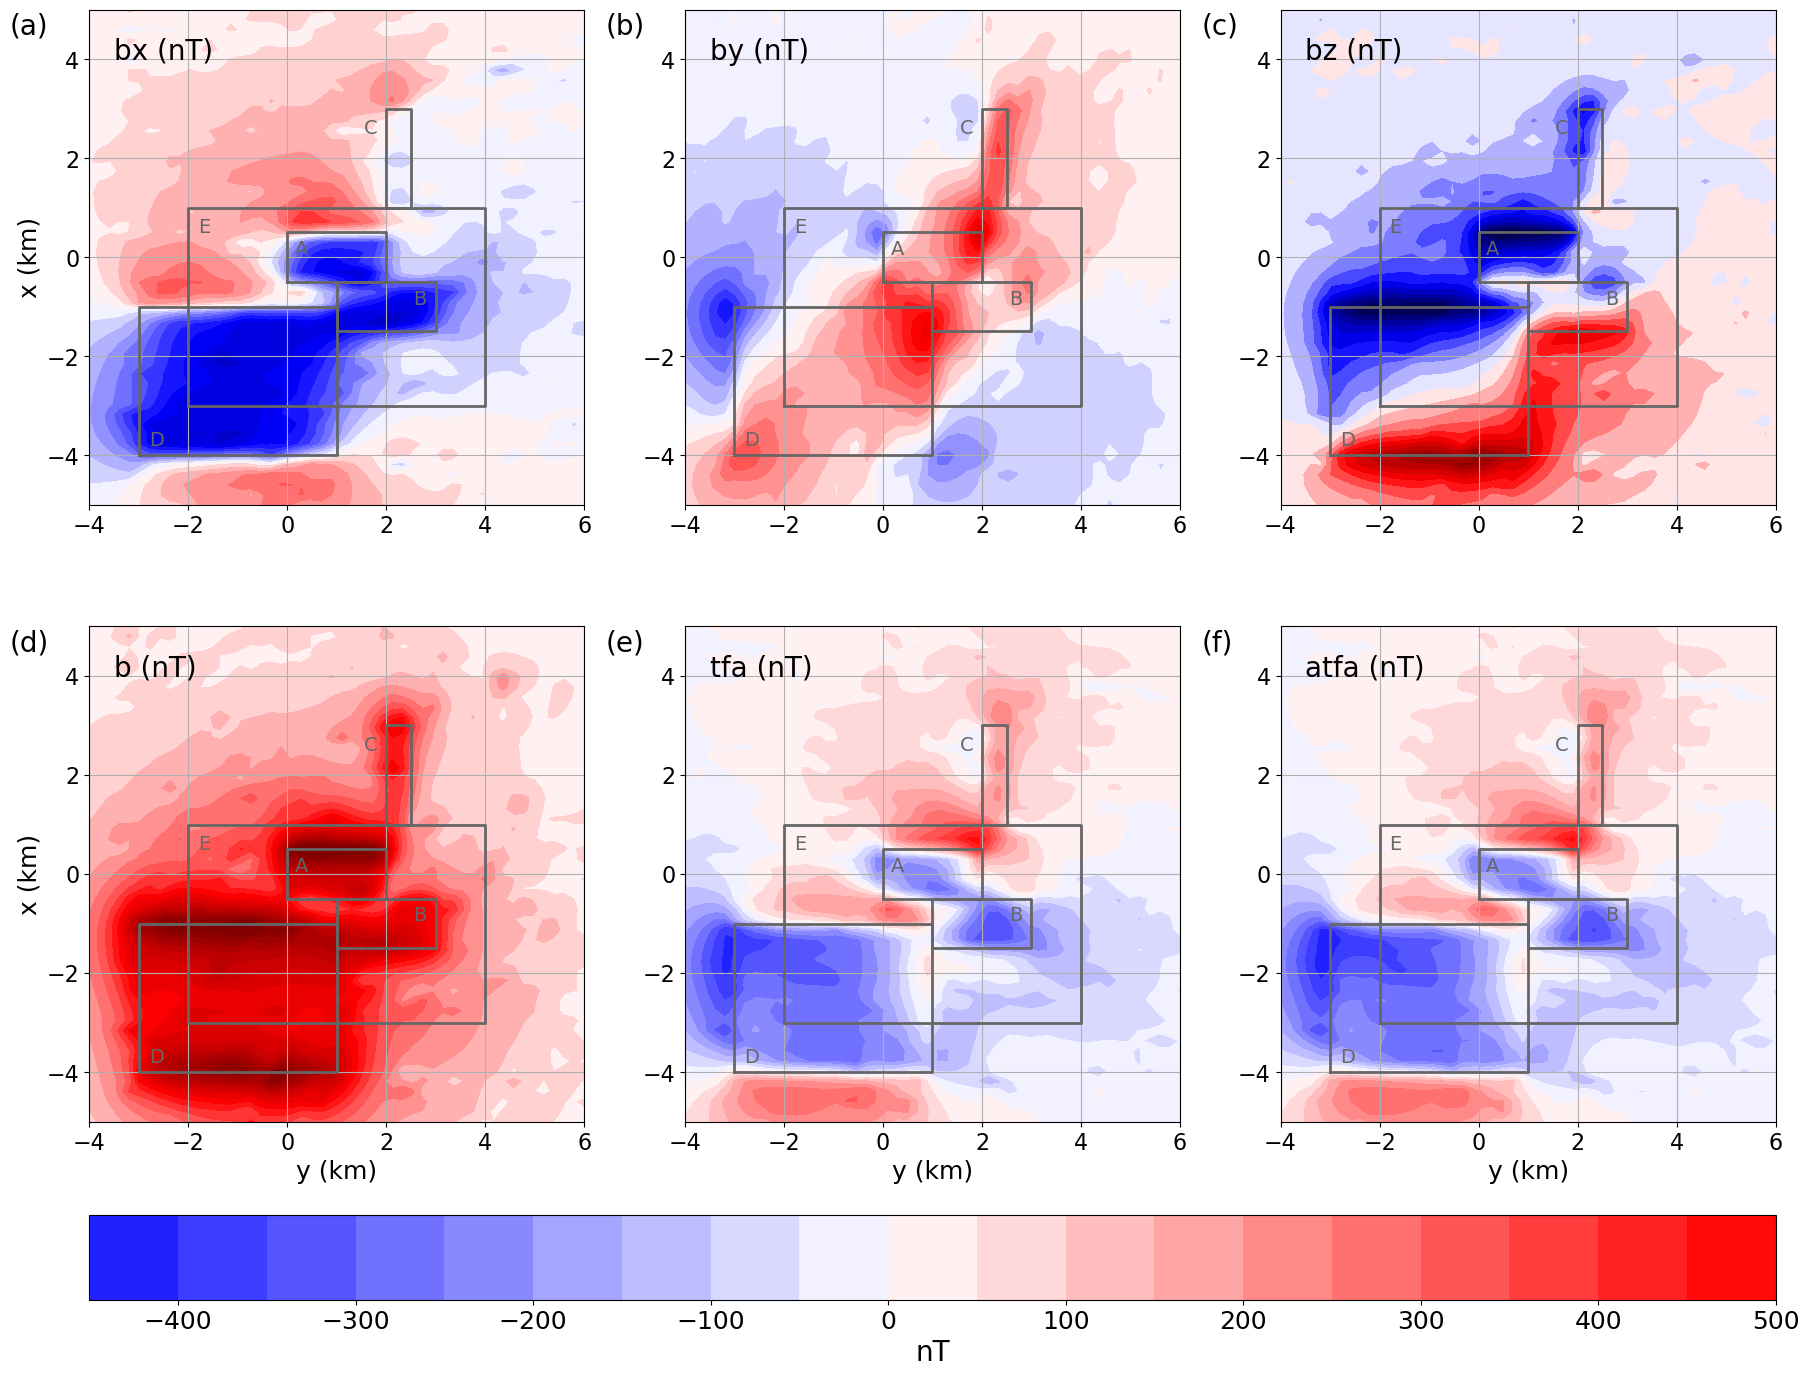

In [48]:
fig = plt.figure(layout= 'constrained', figsize=(18,14))
mosaic = fig.subplot_mosaic('''
                            abc
                            def
                            ''')
# tensor components
for (element, field, title, label) in zip(
    mosaic_elements, mag_fields, titles, labels
):
    ax = mosaic[element]
    ax.axis('scaled')
    im = ax.contourf(Y*0.001, X*0.001, 
                     data_structures.grid_xy_full_flatten_to_matrix(
                         data=crustal_field[field],
                         grid_orientation=main_field['grid_orientation'],
                         shape=data_points['shape']
                     ), 20, 
                     cmap='seismic', vmin=-ranges, vmax=ranges)
    ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
    ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid()
    ax.annotate(label, xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)
    ax.annotate(title, xy=(0.05, 0.90), xycoords='axes fraction', fontsize=20)
    plf.model_boundaries(
        ax,
        model=model_cut(model['prisms'], pmin=0, pmax=4),
        color=color,
        style='-',
        width='2'
    )
    ax.annotate(text='A', xy=(0.15, 0.05), fontsize=14, color=color)
    ax.annotate(text='B', xy=(2.55, -0.95), fontsize=14, color=color)
    ax.annotate(text='C', xy=(1.55, 2.50), fontsize=14, color=color)
    ax.annotate(text='D', xy=(-2.80, -3.80), fontsize=14, color=color)
    ax.annotate(text='E', xy=(-1.80, 0.50), fontsize=14, color=color)

for element in ['a','d']:
    mosaic[element].set_ylabel('x (km)', fontsize=18)
for element in ['d','e', 'f']:
    mosaic[element].set_xlabel('y (km)', fontsize=18)

cb = fig.colorbar(
    mosaic['f'].collections[0], 
    ax=[mosaic['d'], mosaic['e'], mosaic['f']], 
    location='bottom'
)
cb.ax.tick_params(labelsize=18)
cb.ax.set_xlabel('nT', fontsize=20, loc='center')

plt.show()

In [53]:
titles = ['tfa', 'atfa', 'atfa - tfa']
labels = ['(a)', '(b)', '(c)']

In [54]:
ranges_tfa = np.max(np.abs(crustal_field['tfa']))
ranges = [
    ranges_tfa, ranges_tfa, 
    np.max(np.abs(crustal_field['atfa'] - crustal_field['tfa']))
]

In [55]:
mosaic_elements = ['a', 'b', 'c']

In [56]:
color = 3*(0.4,)

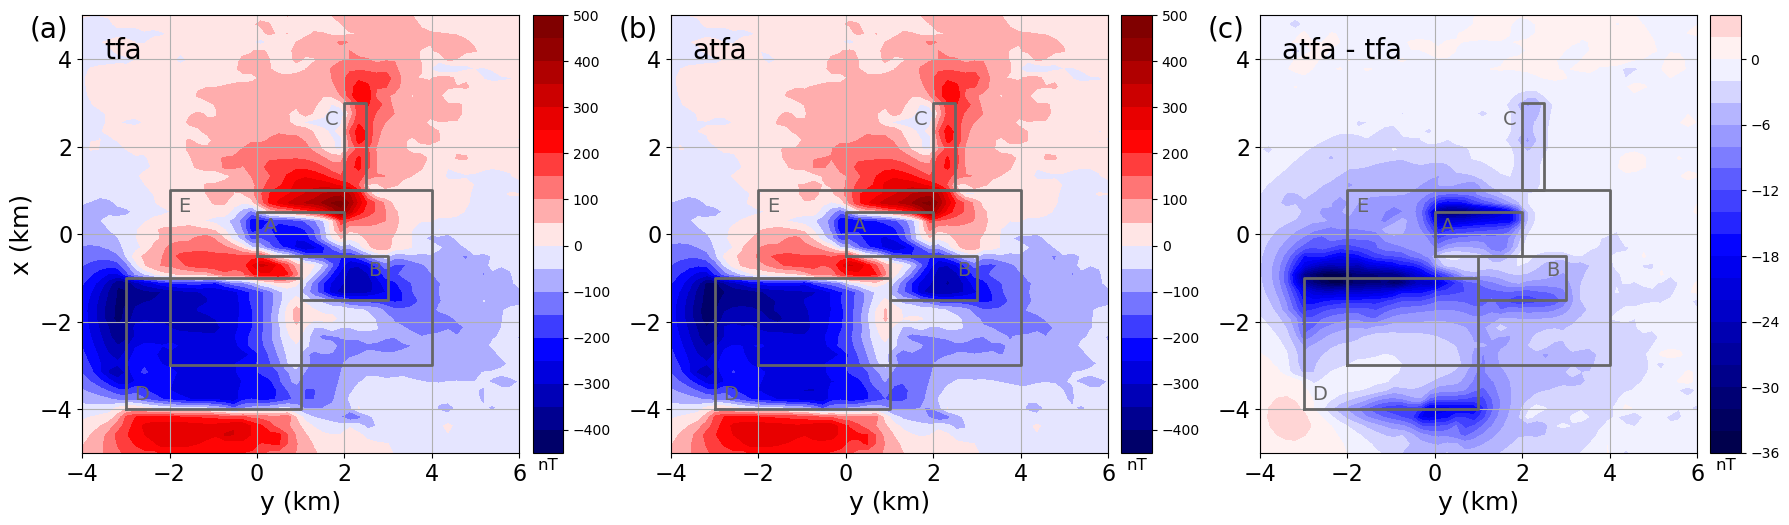

In [64]:
fig = plt.figure(layout= 'tight', figsize=(18,7))
mosaic = fig.subplot_mosaic('''
                            abc
                            ''')
# tensor components
for (element, field, title, label, ranges_field) in zip(
    mosaic_elements, 
    [crustal_field['tfa'], crustal_field['atfa'], crustal_field['atfa'] - crustal_field['tfa']], 
    titles, labels, ranges
):
    ax = mosaic[element]
    ax.axis('scaled')
    im = ax.contourf(Y*0.001, X*0.001, 
                     data_structures.grid_xy_full_flatten_to_matrix(
                         data=field,
                         grid_orientation=main_field['grid_orientation'],
                         shape=data_points['shape']
                     ), 20, 
                     cmap='seismic', vmin=-ranges_field, vmax=ranges_field)
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="7%", pad="3%")
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    cb.ax.tick_params(labelsize=10, top=False, bottom=True, labeltop=False, labelbottom=True)
    cb.ax.set_xlabel('nT', fontsize=12, loc='center')
    ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
    ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid()
    ax.annotate(label, xy=(-0.12, 0.95), xycoords='axes fraction', fontsize=20)
    ax.annotate(title, xy=(0.05, 0.90), xycoords='axes fraction', fontsize=20)
    plf.model_boundaries(
        ax,
        model=model_cut(model['prisms'], pmin=0, pmax=4),
        color=color,
        style='-',
        width='2'
    )
    ax.annotate(text='A', xy=(0.15, 0.05), fontsize=14, color=color)
    ax.annotate(text='B', xy=(2.55, -0.95), fontsize=14, color=color)
    ax.annotate(text='C', xy=(1.55, 2.50), fontsize=14, color=color)
    ax.annotate(text='D', xy=(-2.80, -3.80), fontsize=14, color=color)
    ax.annotate(text='E', xy=(-1.80, 0.50), fontsize=14, color=color)

for element in ['a']:
    mosaic[element].set_ylabel('x (km)', fontsize=18)
for element in ['a','b','c']:
    mosaic[element].set_xlabel('y (km)', fontsize=18)

plt.show()

In [65]:
titles = ['tfa', 'b', 'rtp']
labels = ['(a)', '(b)', '(c)']

In [66]:
mag_fields = ['tfa', 'b', 'rtp']

In [67]:
ranges = []
for field in mag_fields:
    ranges.append(np.max(np.abs(crustal_field[field])))
ranges = 0.9*np.max(np.array(ranges))

In [68]:
mosaic_elements = ['a', 'b', 'c']

In [69]:
color = 3*(0.4,)

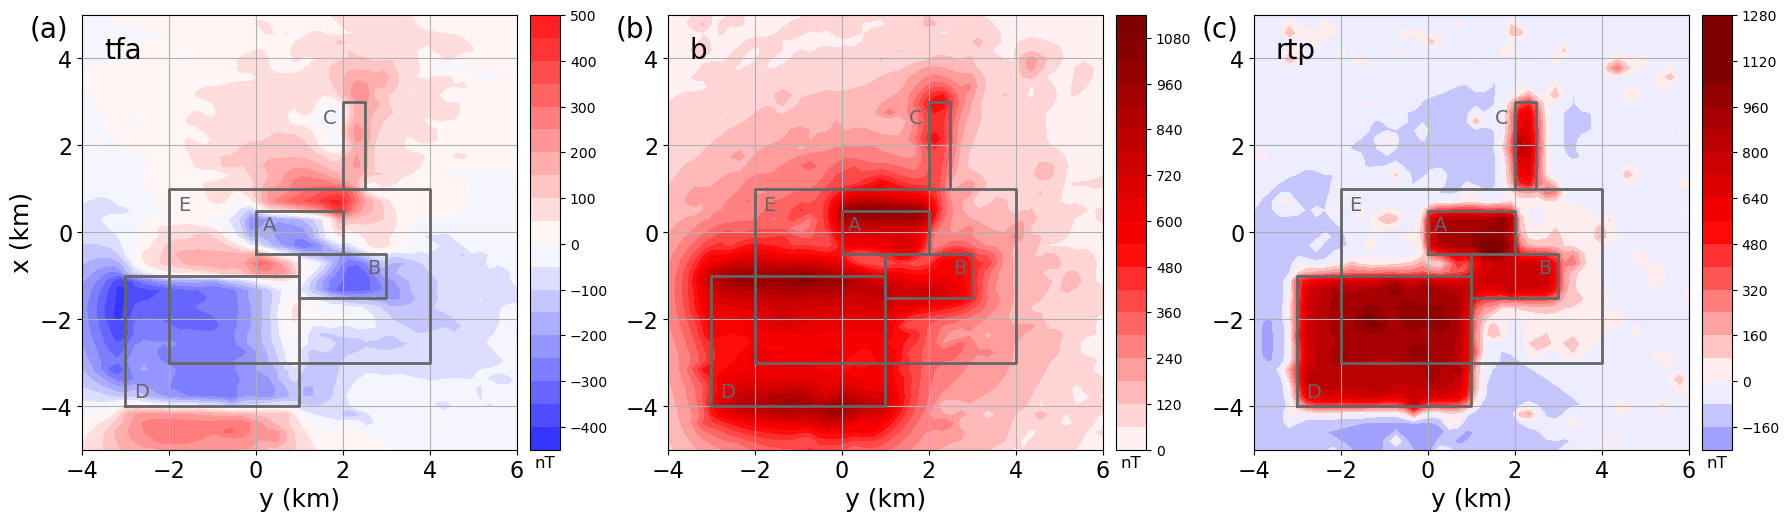

In [72]:
fig = plt.figure(layout= 'tight', figsize=(18,7))
mosaic = fig.subplot_mosaic('''
                            abc
                            ''')
# tensor components
for (element, field, title, label) in zip(
    mosaic_elements, mag_fields, titles, labels
):
    ax = mosaic[element]
    ax.axis('scaled')
    im = ax.contourf(Y*0.001, X*0.001, 
                     data_structures.grid_xy_full_flatten_to_matrix(
                         data=crustal_field[field],
                         grid_orientation=main_field['grid_orientation'],
                         shape=data_points['shape']
                     ), 20, 
                     cmap='seismic', vmin=-ranges, vmax=ranges)
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="7%", pad="3%")
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    cb.ax.tick_params(labelsize=10, top=False, bottom=True, labeltop=False, labelbottom=True)
    cb.ax.set_xlabel('nT', fontsize=12, loc='center')
    ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
    ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid()
    ax.annotate(label, xy=(-0.12, 0.95), xycoords='axes fraction', fontsize=20)
    ax.annotate(title, xy=(0.05, 0.90), xycoords='axes fraction', fontsize=20)
    plf.model_boundaries(
        ax,
        model=model_cut(model['prisms'], pmin=0, pmax=4),
        color=color,
        style='-',
        width='2'
    )
    ax.annotate(text='A', xy=(0.15, 0.05), fontsize=14, color=color)
    ax.annotate(text='B', xy=(2.55, -0.95), fontsize=14, color=color)
    ax.annotate(text='C', xy=(1.55, 2.50), fontsize=14, color=color)
    ax.annotate(text='D', xy=(-2.80, -3.80), fontsize=14, color=color)
    ax.annotate(text='E', xy=(-1.80, 0.50), fontsize=14, color=color)

for element in ['a']:
    mosaic[element].set_ylabel('x (km)', fontsize=18)
for element in ['a','b', 'c']:
    mosaic[element].set_xlabel('y (km)', fontsize=18)

plt.show()